# Imports 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy

In [2]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
%matplotlib inline

# Data loading

In [3]:
data_train = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\train.csv')
data_test = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\test.csv')
#test_labels = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\test_labels.csv')
sample_submission = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\sample_submission.csv')

# EDA

In [4]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Псмотрим сколько всего нетоксичных и всяких токсичных комментов 

In [51]:
x = data_train.iloc[:,2:].sum()
rowsums=data_train.iloc[:,2:].sum(axis=1)
print("Total comments ",data_train.shape[0])
print("Nomber of non-toxic comments",list(pd.DataFrame(rowsums==0).sum())[0])
print("Total toxic ",x.sum())

Total comments  159571
Nomber of non-toxic comments 143346
Total toxic  35098


Получается у нас топик может быть разнообразно токсичен (то есть и угроза и обзывательство и тд). Посмотрим как распределены комменты по различным токсичностям.

In [52]:
col_names = data_train.columns.values[2:]
col_names = col_names.tolist()
col_names.append('None')
x = [sum(data_train[y]) for y in data_train.columns.values[2:]]
x.append(len(data_train) - sum(x))

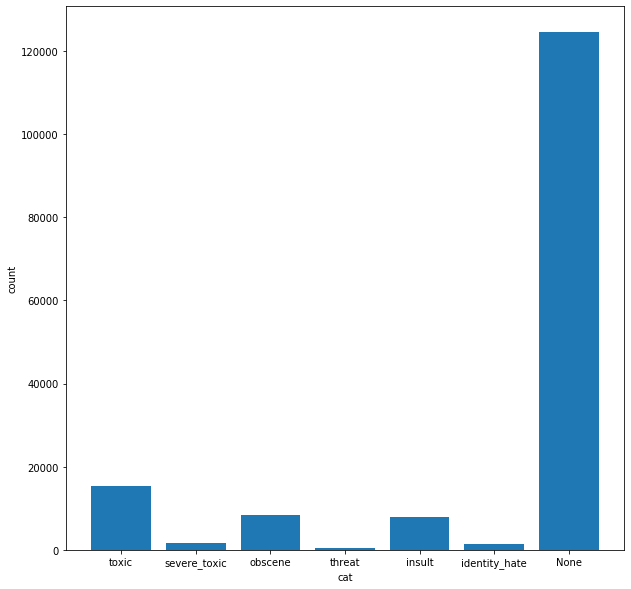

In [53]:
plt.figure(figsize = (10, 10))
plt.bar(np.arange(len(x)),x)
plt.xticks(np.arange(len(x)), col_names)
plt.xlabel('cat')
plt.ylabel('count')
plt.show()

Классы сильно несбалансиврованы. Еще можно посмотреть на количество текстов с миксом токсик тэгов

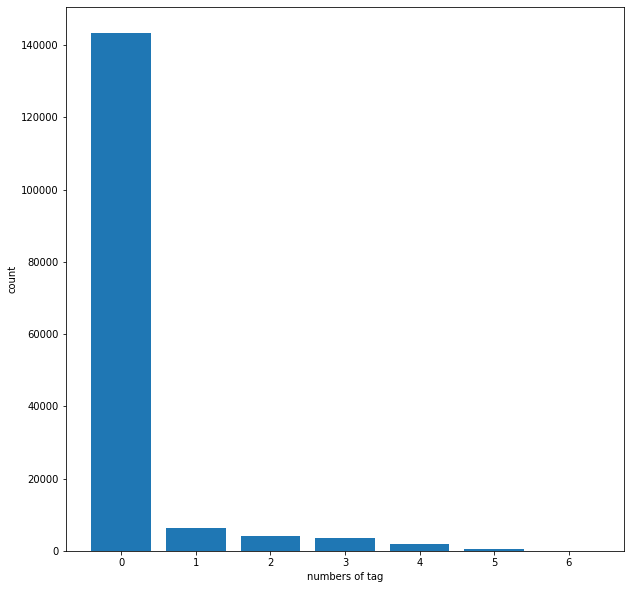

In [48]:
x=rowsums.value_counts()
plt.figure(figsize = (10, 10))
plt.bar(np.arange(len(x)),x)
plt.xticks(np.arange(len(x)))
plt.xlabel('numbers of tag')
plt.ylabel('count')
plt.show()

In [58]:
import seaborn as sns

In [63]:
data_train[data_train.iloc[:,2:].sum(axis=1) != 0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
44,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0


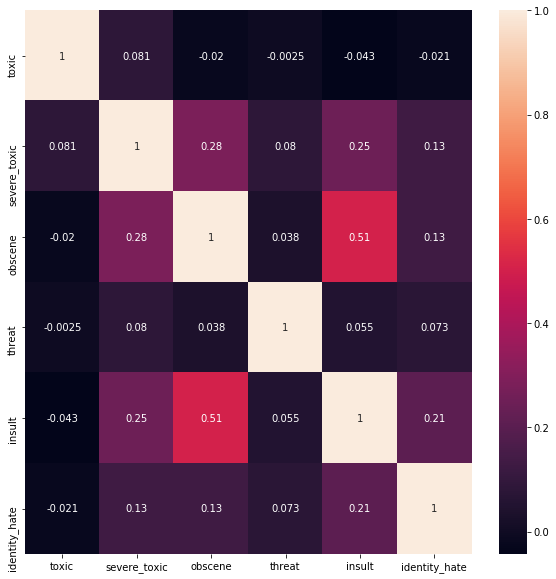

In [61]:
corr = data_train[data_train.iloc[:,2:].sum(axis=1) != 0].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            annot=True
           )
            

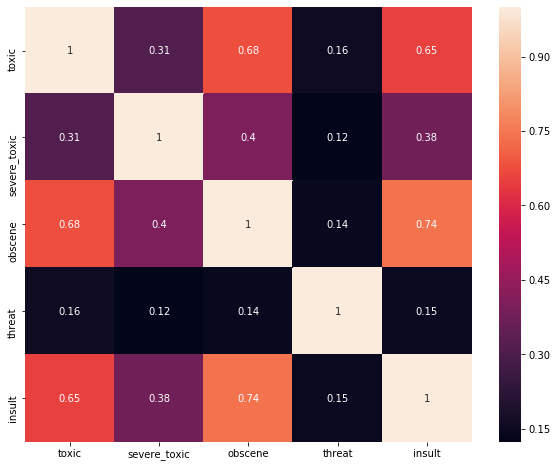

In [64]:
temp_df=data_train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

# Preprocessing

In [40]:
def cleaning(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [41]:
data_train = cleaning(data_train, 'comment_text')
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero any chance you remember...",0,0,0,0,0,0


In [42]:
data_test = cleaning(data_test, 'comment_text')
data_test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...
1,0000247867823ef7,from rfc \n\n the title is fine as it is...
2,00013b17ad220c46,""" \n\n sources \n\n zawe ashton on lap..."
3,00017563c3f7919a,"if you have a look back at the source, the in..."
4,00017695ad8997eb,i don't anonymously edit articles at all


### Adding tokens

In [52]:
# separating text for tokens using reg. exp.
tokenizer = RegexpTokenizer(r'\w+')
data_train['tokens'] = data_train['comment_text'].apply(tokenizer.tokenize)

In [61]:
# deleting stop words
data_train['tokens'] = data_train['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [65]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore,..."
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,"[aww, matches, background, colour, seemingly, ..."
2,000113f07ec002fd,"hey man, i'm really not trying to edit war it...",0,0,0,0,0,0,"[hey, man, really, trying, edit, war, guy, con..."
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,"[make, real, suggestions, improvement, wondere..."
4,0001d958c54c6e35,"you, sir, are my hero any chance you remember...",0,0,0,0,0,0,"[sir, hero, chance, remember, page]"


In [69]:
words = [word for tokens in data_train['tokens'] for word in tokens]
vocab = set(words)
vocab_size = len(vocab)
print('Vocabulary size', vocab_size)

Vocabulary size 175303


In [68]:
len(set(words))

175303